<a href="https://colab.research.google.com/github/Joana-Mansa/zindi_burnt_area_challenge/blob/main/new_fire_fighting_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fighting Fire with Data - Starter Notebook

This notebook should help you get started with the 'Fighting Fire with Data' hackathon on Zindi. In it we cover:
- Loading the data
- Simple EDA and an example of feature enginnering
- Suggestions for validation split
- Creating a simple model
- Making a submission
- Some tips for improving your score


# Setup

Make sure the files are available in the current directory. On Colab, upload them using the files tab on the left.

In [ ]:
# mounting google drive
from google.colab import drive

drive.mount('/content/drive')
data_dir = "/content/drive/My Drive/fire-extent-prediction-challenge/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Libraries Used

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# The training data.
var_defs = pd.read_csv('/content/drive/My Drive/fire-extent-prediction-challenge/variable_definitions.csv')
var_defs

,Variable,Description
0,ID,The IDs take the form of [area ID]_yyyy-mm-dd....
1,area,Area ID
2,date,The date that the data is aggregated over
3,lat,Latitude of the center of the area
4,lon,Longitude of the center of the area
5,burn_area,Percentage of the area burnt
6,climate_aet,"Actual evapotranspiration, derived using a one..."
7,climate_def,"Climate water deficit, derived using a one-dim..."
8,climate_pdsi,Palmer Drought Severity Index
9,climate_pet,Reference evapotranspiration (ASCE Penman-Mont...


In [ ]:
# The training data.
train = pd.read_csv('/content/drive/My Drive/fire-extent-prediction-challenge/Train.csv')
train.head()

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,...,0.0,0.0,0.018654,0.0,0.714446,0.012174,0.244890,0.009836,0.0,0.256932
1,1_2001-01-01,-15.858835,29.487029,0.0,1196,0,232,1196,201,10,...,0.0,0.0,0.000000,0.0,0.654783,0.000095,0.345121,0.000000,0.0,0.273093
2,2_2001-01-01,-15.858835,29.737029,0.0,1190,0,314,1190,192,10,...,0.0,0.0,0.000000,0.0,0.516421,0.000000,0.483579,0.000000,0.0,0.285109
3,3_2001-01-01,-15.858835,29.987029,0.0,1144,0,321,1144,186,66,...,0.0,0.0,0.000000,0.0,0.299000,0.163902,0.537098,0.000000,0.0,0.298418
4,4_2001-01-01,-15.858835,30.237029,0.0,1187,0,413,1187,186,9,...,0.0,0.0,0.000000,0.0,0.277392,0.067742,0.654866,0.000000,0.0,0.315621


In [ ]:
# The test set - notice there is no 'burn_area' column.
test = pd.read_csv('/content/drive/My Drive/fire-extent-prediction-challenge/Test.csv')
test.head(1)

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,...,0.0,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243


# EDA + Feature Engineering

In [ ]:
# Look at distribution of each variable
train.describe()

,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
count,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,...,83148.000000,83148.000000,83148.000000,8.314800e+04,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000
mean,-19.014557,29.860856,0.007632,484.491124,828.892721,-30.806237,1313.382992,54.576322,6.215134,305.477919,...,0.006158,0.000017,0.008583,4.066313e-08,0.160628,0.037453,0.785382,0.000354,0.001424,0.078551
std,1.588444,1.751090,0.029226,470.467480,546.934469,235.802930,315.209838,71.997561,21.480399,400.956123,...,0.053111,0.000141,0.059046,3.535121e-06,0.192957,0.106050,0.233953,0.001773,0.014233,0.104464
min,-22.358835,25.487029,0.000000,0.000000,0.000000,-563.000000,587.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000
25%,-20.358835,28.487029,0.000000,50.000000,375.000000,-212.000000,1081.000000,1.000000,0.000000,70.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.014993,0.000000,0.655322,0.000000,0.000000,0.002017
50%,-18.858835,29.987029,0.000000,302.000000,858.000000,-108.000000,1290.000000,22.000000,1.000000,149.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.076706,0.000139,0.880600,0.000000,0.000000,0.028503
75%,-17.858835,31.237029,0.000000,931.000000,1211.000000,142.000000,1517.000000,87.000000,4.000000,329.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.246498,0.015166,0.971209,0.000000,0.000000,0.125500
max,-15.858835,32.987029,0.843886,1713.000000,2614.000000,851.000000,2620.000000,501.000000,342.000000,3319.000000,...,0.828131,0.004918,0.711603,3.073689e-04,0.981472,0.881323,1.000000,0.016708,0.301823,0.801328


<Axes: >

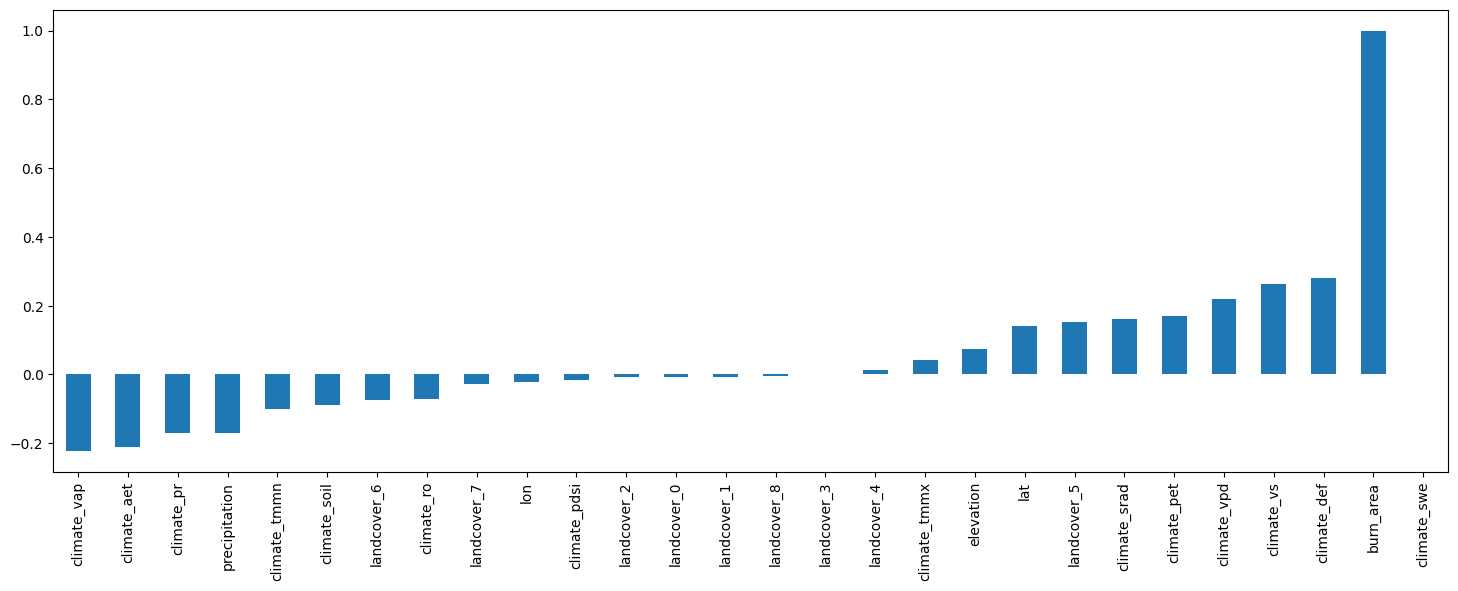

In [ ]:
# Look at correlation with target
train.select_dtypes(include=['number']).corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

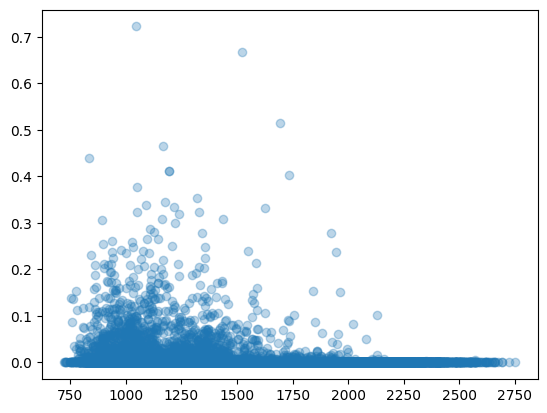

In [ ]:
# Look at some scatter plots (only plotting for a subset of data to keep things fast)
sample = train.sample(10000)
plt.scatter(sample['climate_vap'], sample['burn_area'], alpha=0.3)

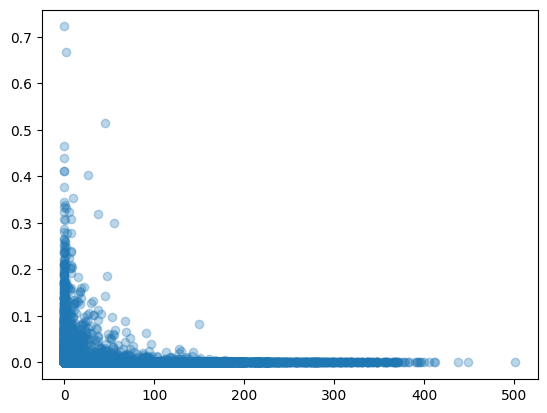

In [ ]:
# Most fires occur when there's very little rain.
plt.scatter(sample['climate_pr'], sample['burn_area'], alpha=0.3)

##  Adding date features

In [ ]:
# Split the ID (eg 127_2017-01-03) to get the date string, which we convert to datetime to make life easier
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))

In [ ]:
train['date'][1]

Timestamp('2001-01-01 00:00:00')

In [ ]:
train.head()

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,...,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation,date
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,...,0.0,0.018654,0.0,0.714446,0.012174,0.244890,0.009836,0.0,0.256932,2001-01-01
1,1_2001-01-01,-15.858835,29.487029,0.0,1196,0,232,1196,201,10,...,0.0,0.000000,0.0,0.654783,0.000095,0.345121,0.000000,0.0,0.273093,2001-01-01
2,2_2001-01-01,-15.858835,29.737029,0.0,1190,0,314,1190,192,10,...,0.0,0.000000,0.0,0.516421,0.000000,0.483579,0.000000,0.0,0.285109,2001-01-01
3,3_2001-01-01,-15.858835,29.987029,0.0,1144,0,321,1144,186,66,...,0.0,0.000000,0.0,0.299000,0.163902,0.537098,0.000000,0.0,0.298418,2001-01-01
4,4_2001-01-01,-15.858835,30.237029,0.0,1187,0,413,1187,186,9,...,0.0,0.000000,0.0,0.277392,0.067742,0.654866,0.000000,0.0,0.315621,2001-01-01


In [ ]:
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

In [ ]:
# Assuming your date column is named 'Date'

train['day'] = train.date.dt.day
train['day_of_week'] = train.date.dt.dayofweek
train['hour'] = train.date.dt.hour


In [ ]:
train.columns

Index(['ID', 'lat', 'lon', 'burn_area', 'climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation', 'date', 'month', 'year', 'day',
       'day_of_week', 'hour'],
      dtype='object')

In [ ]:
# Date variables
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['day'] = test.date.dt.day
test['day_of_week'] = test.date.dt.dayofweek
test['hour'] = test.date.dt.hour


In [ ]:
# converts the date into an ordinal number
train['date_ordinal'] = train['date'].apply(lambda x: x.toordinal())
test['date_ordinal'] = test['date'].apply(lambda x: x.toordinal())


In [ ]:
# creates a binary feature for whether or not the incident occured at a peak fire season/month
# from our data, the fire seasons are between 6-11 months
train['is_fire_season'] = train['month'].apply(lambda x: 1 if x in [6, 7, 8, 9, 10, 11] else 0)
test['is_fire_season'] = test['month'].apply(lambda x: 1 if x in [6, 7, 8, 9, 10, 11] else 0)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Create lag features (using burnt_area from previous time steps)
train['lag_1'] = train['burn_area'].shift(1)
train['lag_7'] = train['burn_area'].shift(7)  # Lag by one week

# Create rolling statistics features (e.g., rolling mean and std)
train['rolling_mean_7'] = train['burn_area'].shift(1).rolling(window=7).mean()
train['rolling_std_7'] = train['burn_area'].shift(1).rolling(window=7).std()




In [ ]:
# Drop rows with NaN values created by shifts
train = train.dropna()

# Define features (X) and target (y)
X = train[['year', 'month_sin', 'month_cos', 'date_ordinal', 'is_fire_season',
          'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_std_7']]
y = train['burn_area']

# Split the data into train and test sets (using the most recent data for testing)
train_size = int(0.8 * len(train))
X_train, X_valid = X[:train_size], X[train_size:]
y_train, y_valid = y[:train_size], y[train_size:]

# Initialize and train the Random Forest model
model = RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=42)

Test MSE: 0.026642285149616137


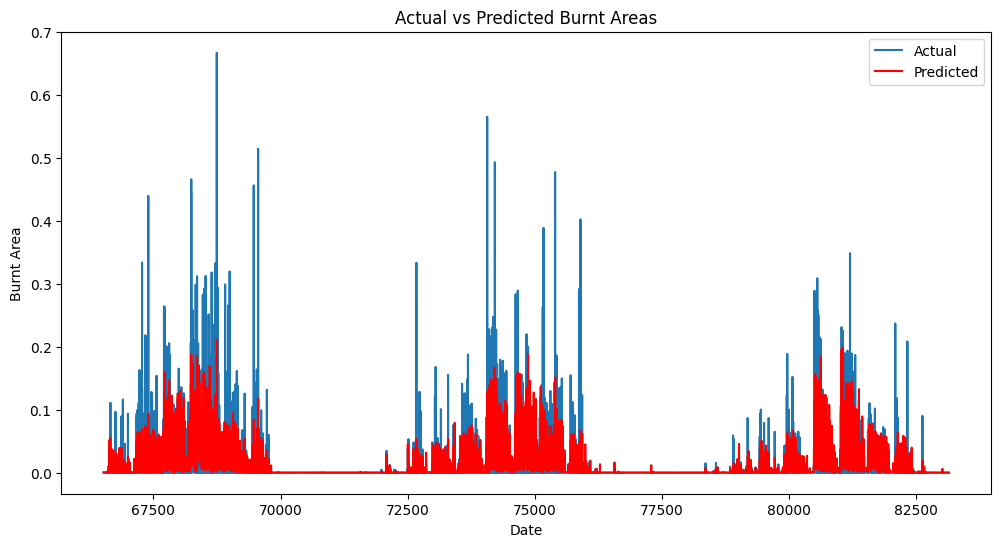

In [ ]:
# Make predictions
y_pred = model.predict(X_valid)

# Evaluate the model using Mean Squared Error
rmse = mean_squared_error(y_valid, y_pred)**0.5
print(f'Test MSE: {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_valid.index, y_valid, label='Actual')
plt.plot(y_valid.index, y_pred, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted Burnt Areas')
plt.xlabel('Date')
plt.ylabel('Burnt Area')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 300, 500],           # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],           # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']   # Number of features to consider when looking for the best split
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get the best model from Grid Search
best_rf = grid_search.best_estimator_



In [ ]:
# Make predictions on the test set
y_pred = best_rf.predict(X_valid)

# Evaluate the model using Mean Squared Error
rmse = mean_squared_error(y_valid, y_pred)**0.5
print(f'Test MSE: {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_valid.index, y_valid, label='Actual')
plt.plot(y_valid.index, y_pred, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted Burnt Areas')
plt.xlabel('Date')
plt.ylabel('Burnt Area')
plt.show()


In [ ]:
# Group by month and calculate the mean burn_area
monthly_mean_burn_area = train.groupby('month')['burn_area'].mean().reset_index()

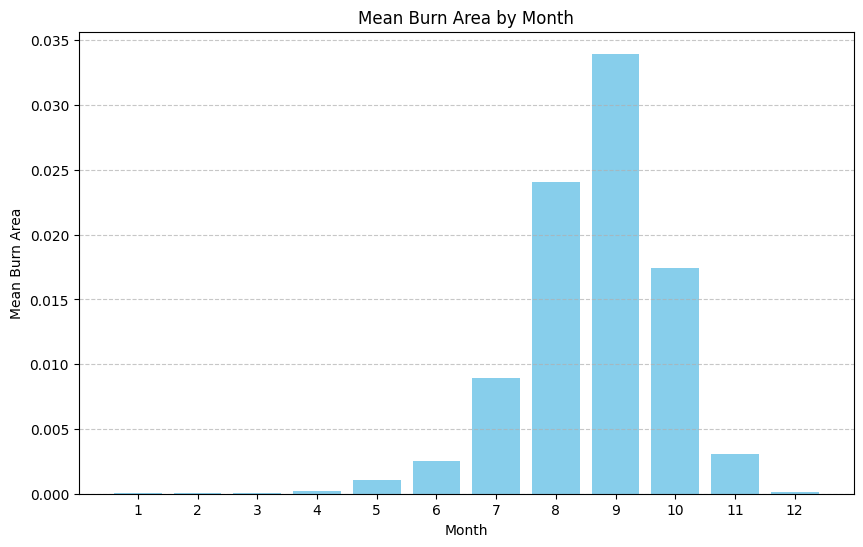

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(monthly_mean_burn_area['month'], monthly_mean_burn_area['burn_area'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Mean Burn Area')
plt.title('Mean Burn Area by Month')
plt.xticks(monthly_mean_burn_area['month'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Group by year and calculate the mean burn_area
yearly_mean_burn_area = train.groupby('year')['burn_area'].mean().reset_index()

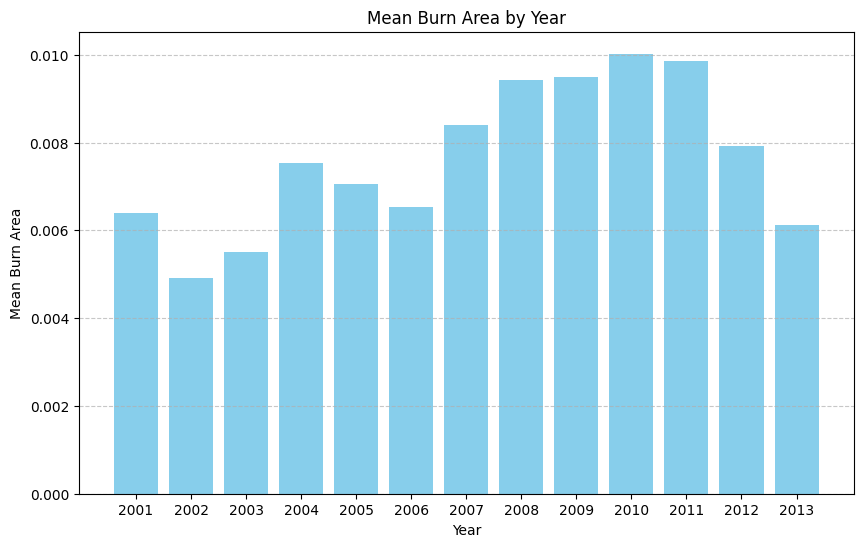

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(yearly_mean_burn_area['year'], yearly_mean_burn_area['burn_area'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Mean Burn Area')
plt.title('Mean Burn Area by Year')
plt.xticks(yearly_mean_burn_area['year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Axes: xlabel='date'>

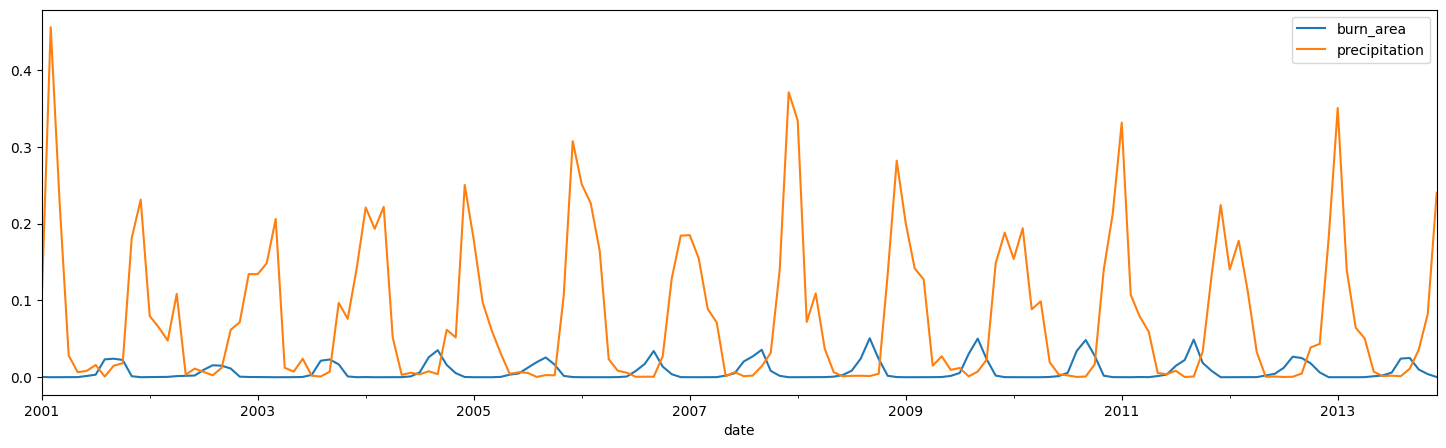

In [ ]:
# Convert 'burn_area' to numeric, handling non-numeric values
train['burn_area'] = pd.to_numeric(train['burn_area'], errors='coerce')

# Now try plotting again
ax = train.groupby('date')['burn_area'].mean().reset_index().plot(y='burn_area', x='date', figsize=(18, 5))
train.groupby('date')['precipitation'].mean().reset_index().plot(y='precipitation', x='date', ax=ax)

### Time Series Analysis

In [ ]:
# encodes the month column to account for its cyclical nature
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)


In [ ]:
# Convert to ordinal for certain models (e.g., trees, regression)
train['date_ordinal'] = train['date'].apply(lambda x: x.toordinal())

# OR

# Example of a specific event feature
data['is_fire_season'] = data['month'].apply(lambda x: 1 if x in [6, 7, 8, 9] else 0)


Visually inspecting for outliers with each feature against the target column

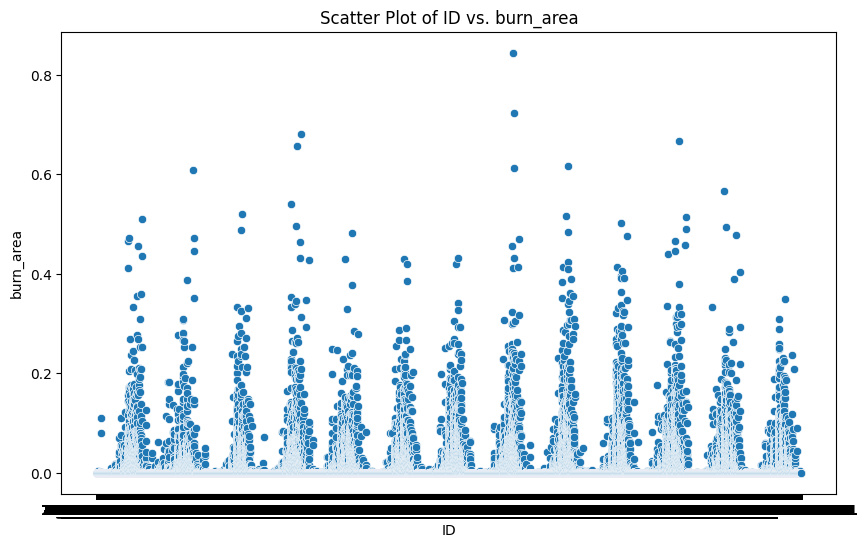

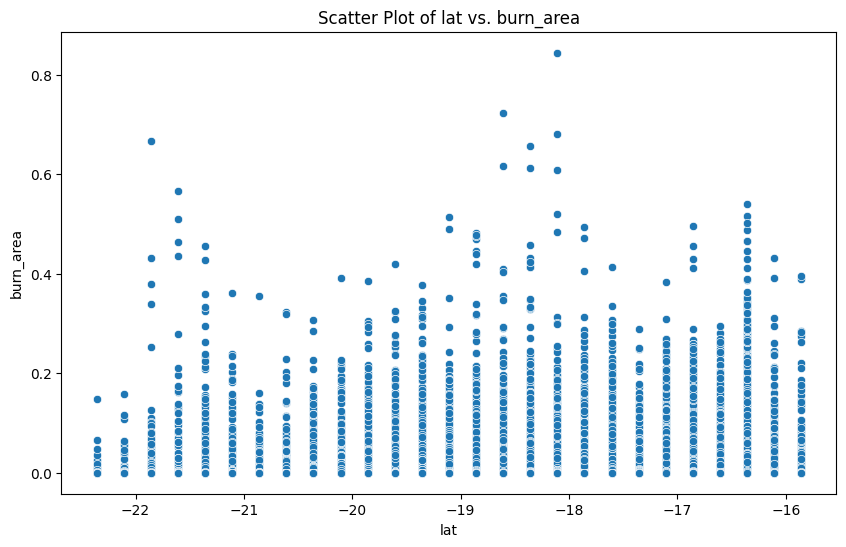

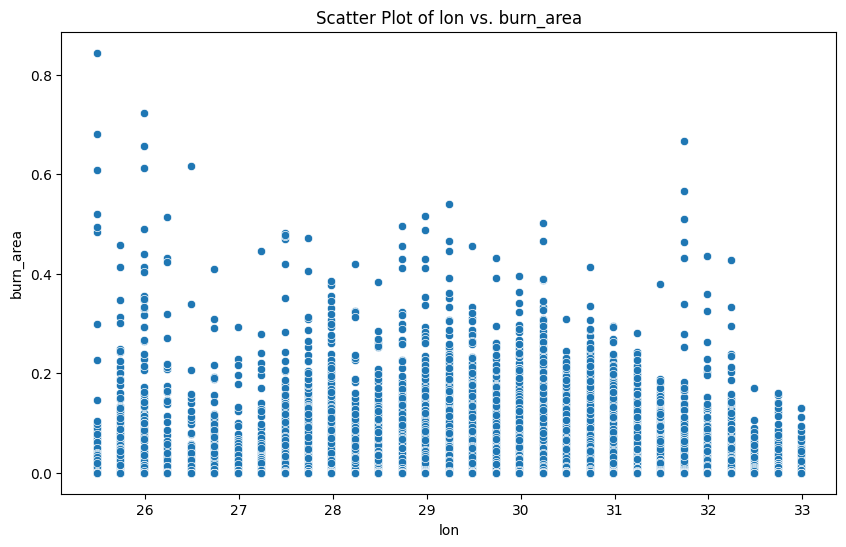

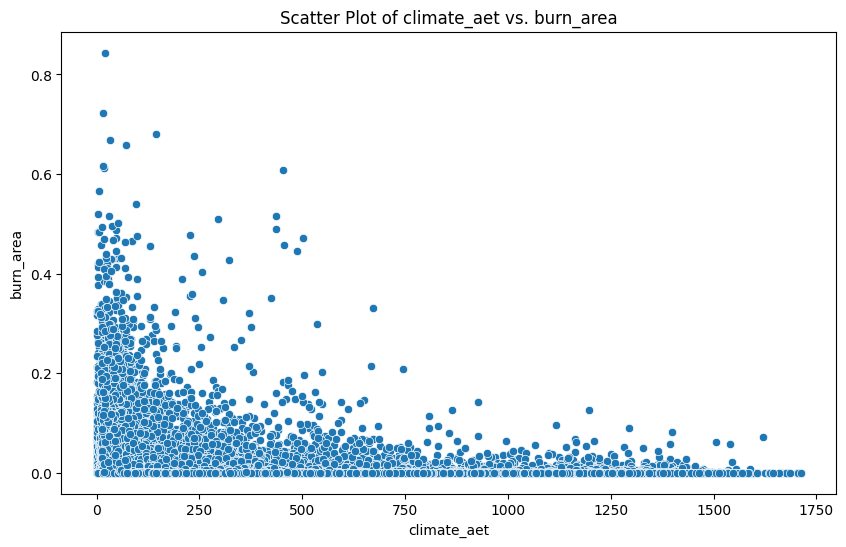

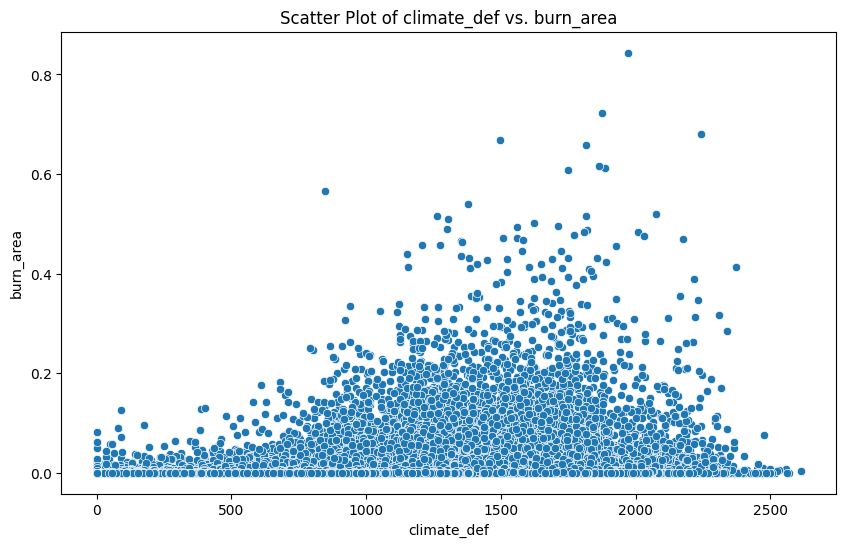

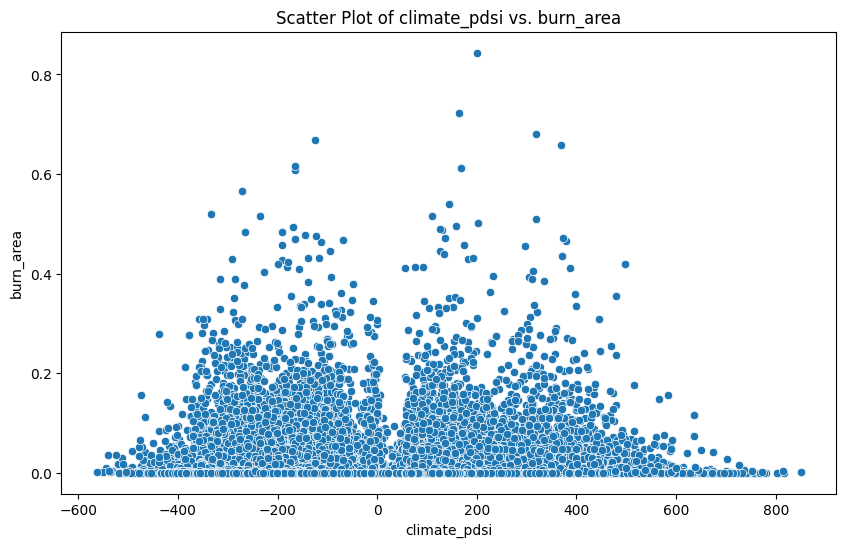

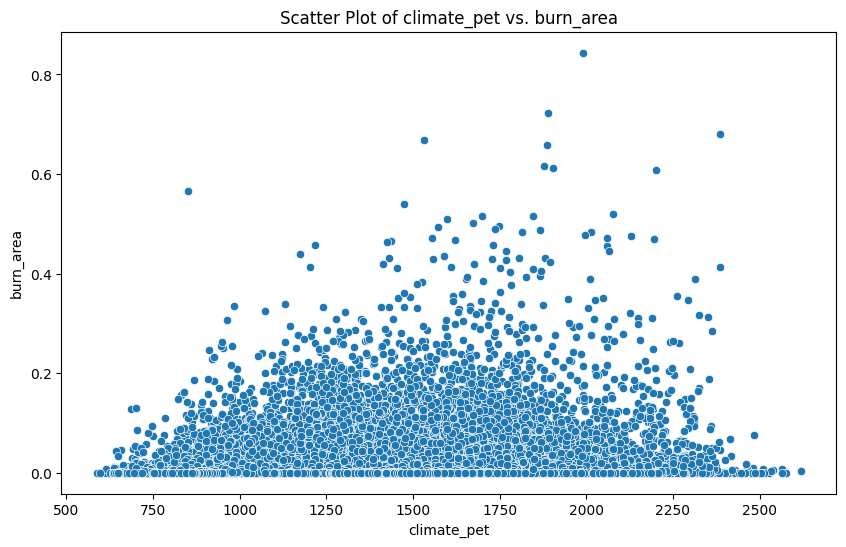

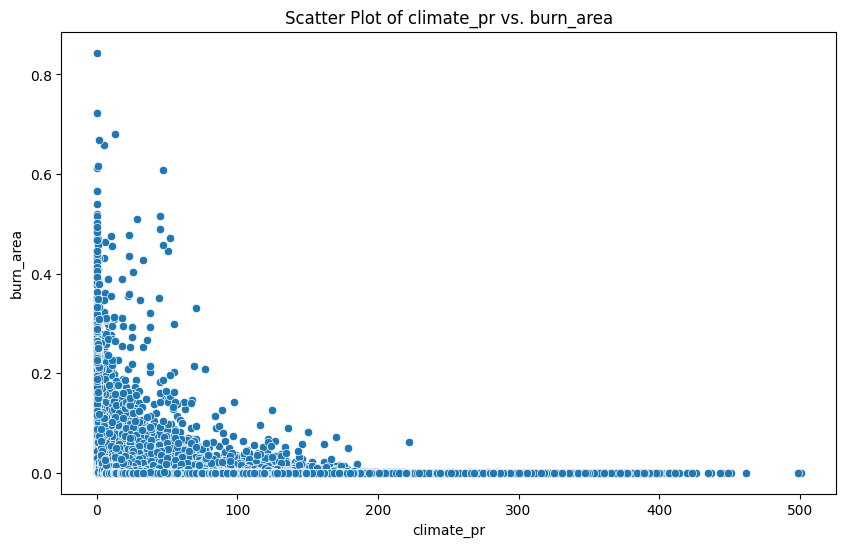

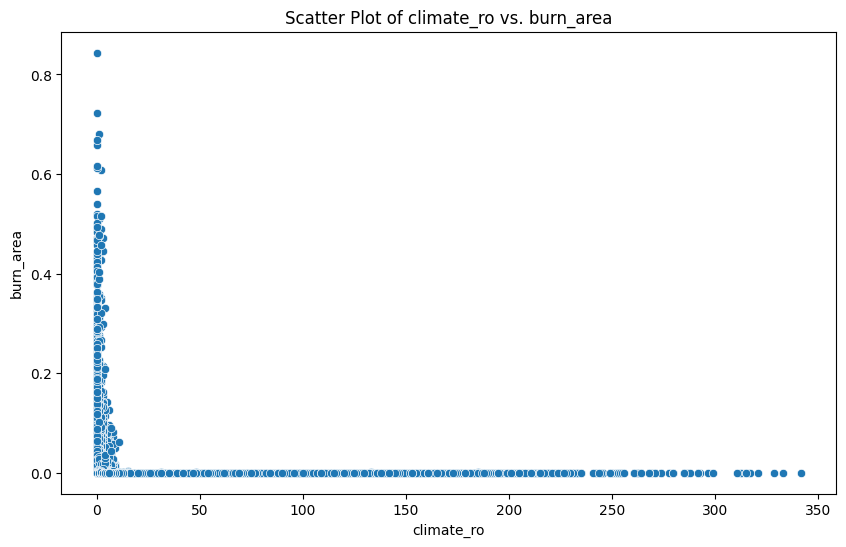

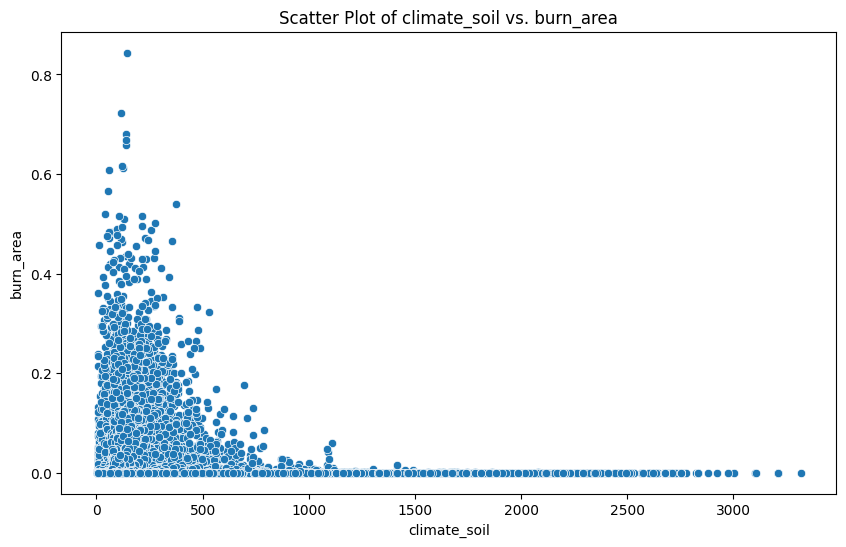

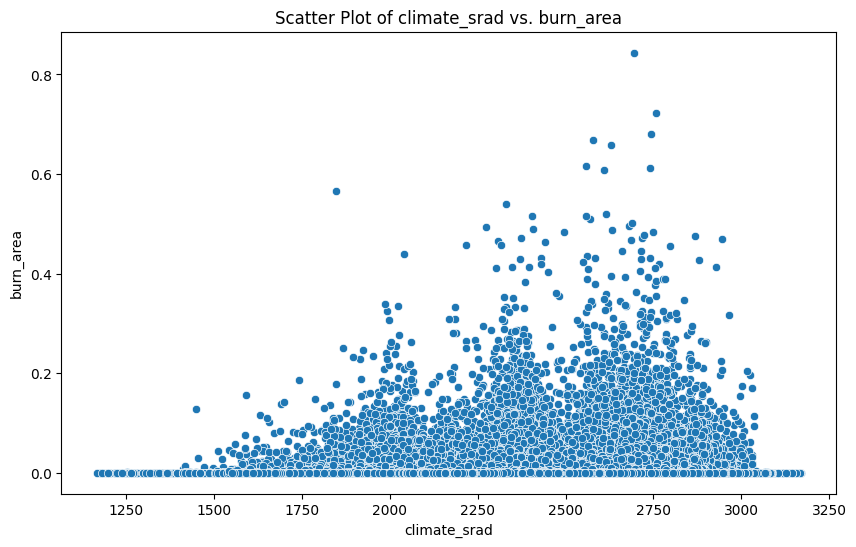

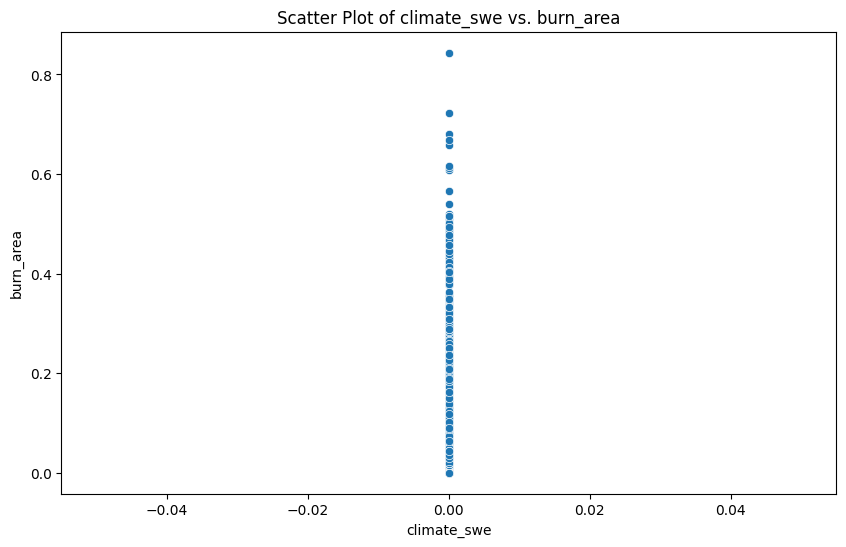

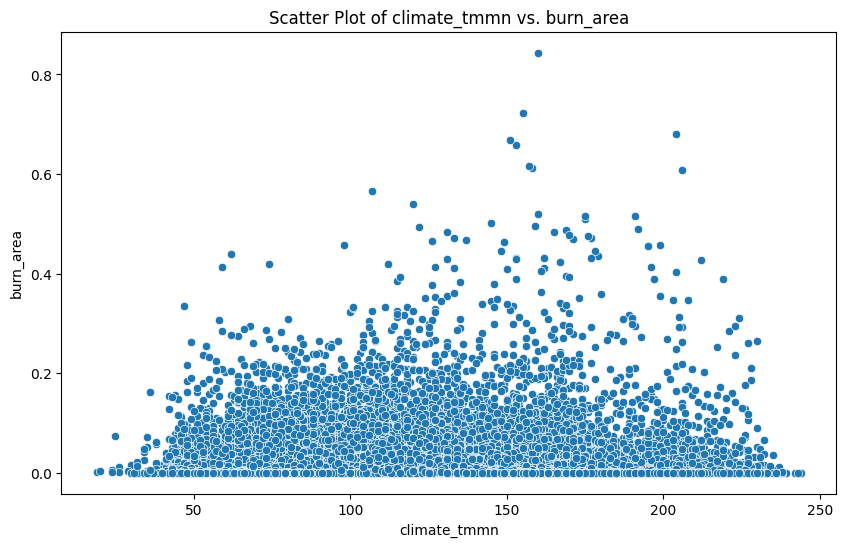

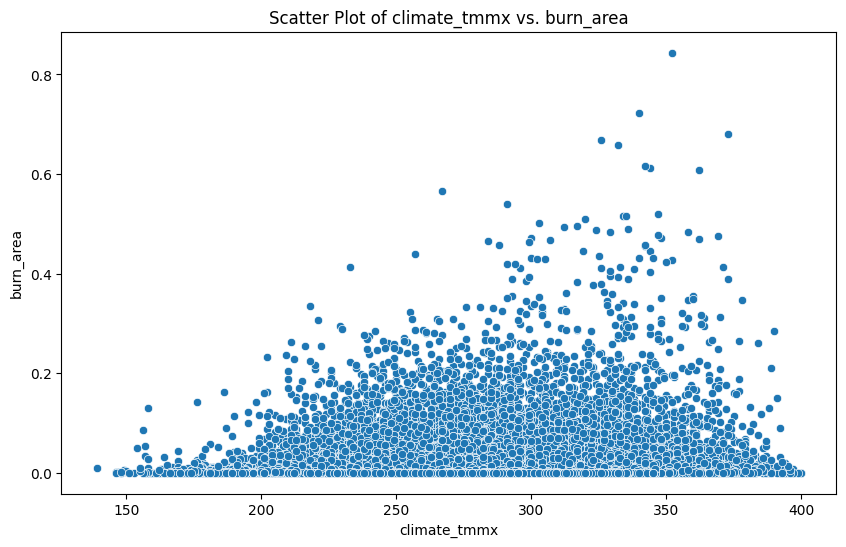

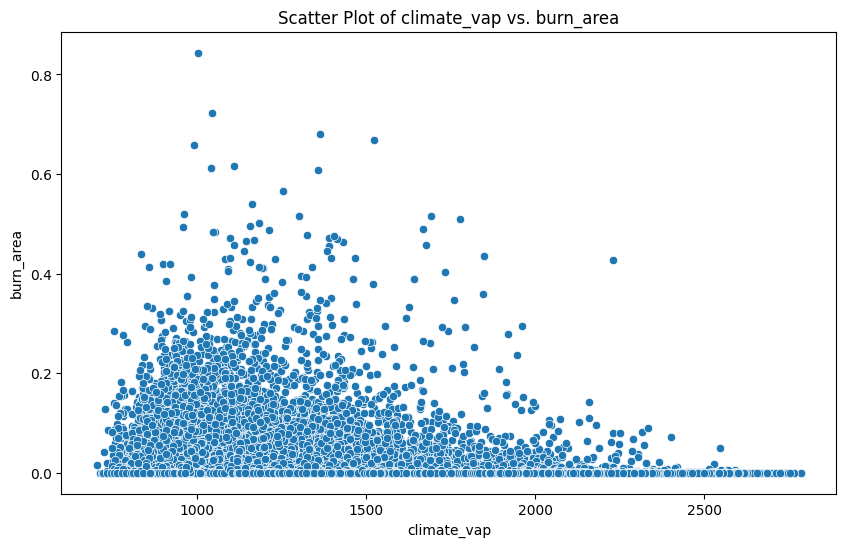

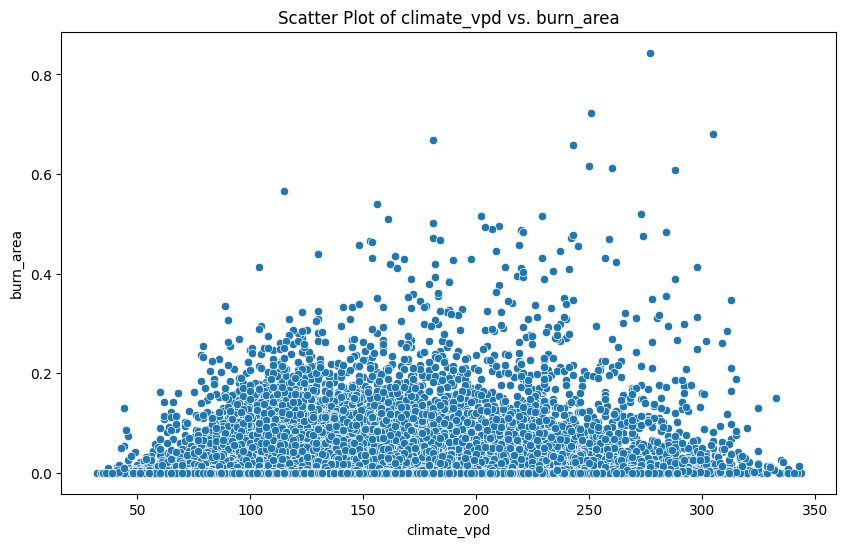

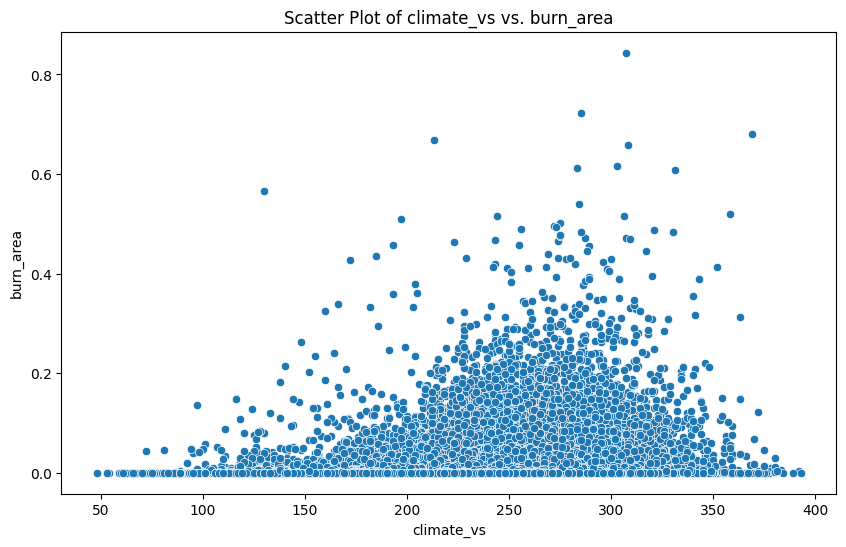

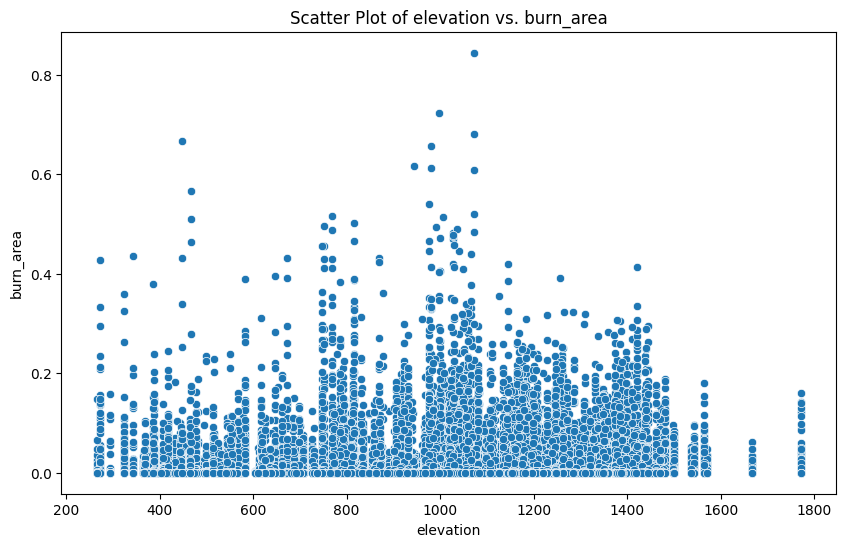

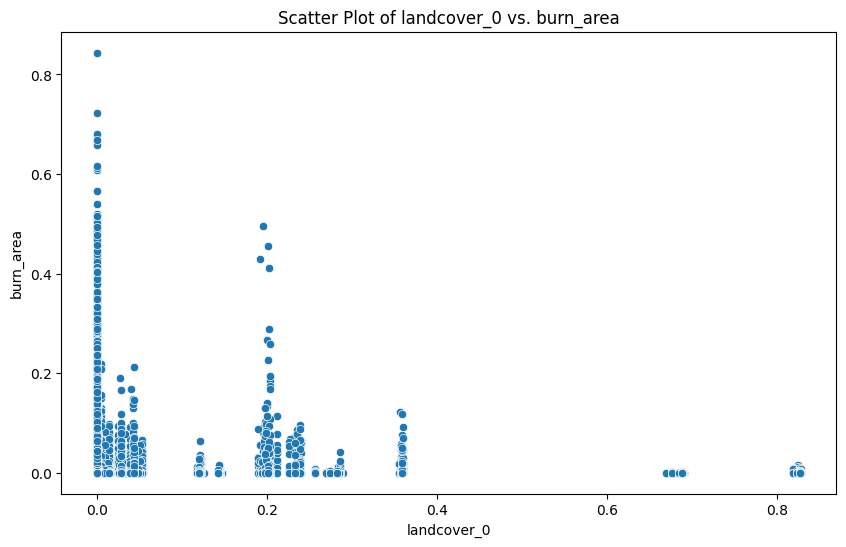

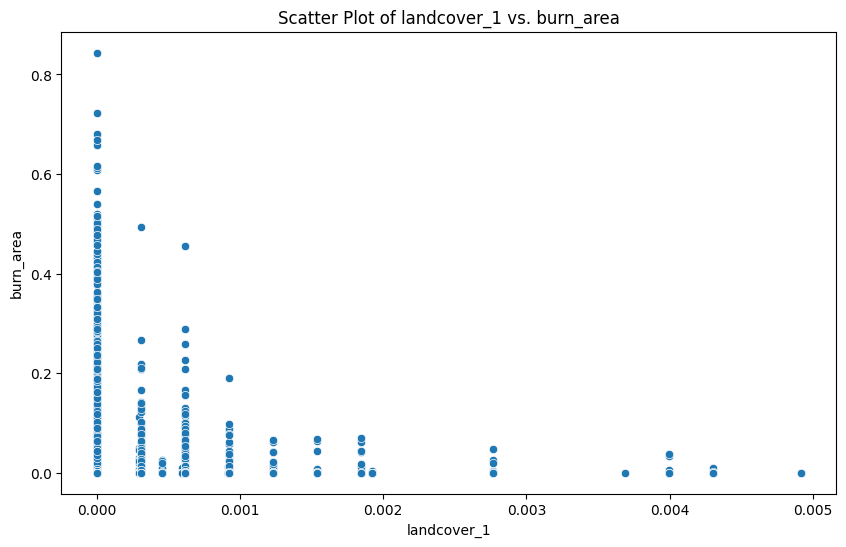

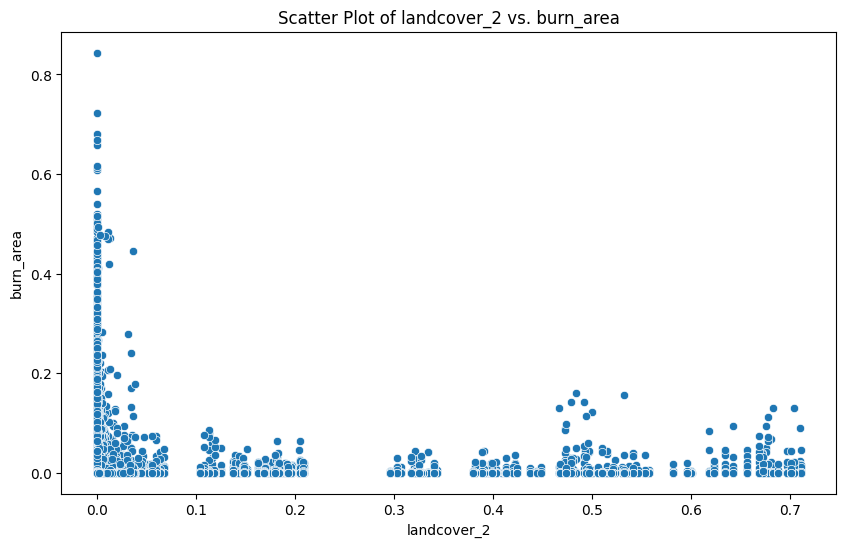

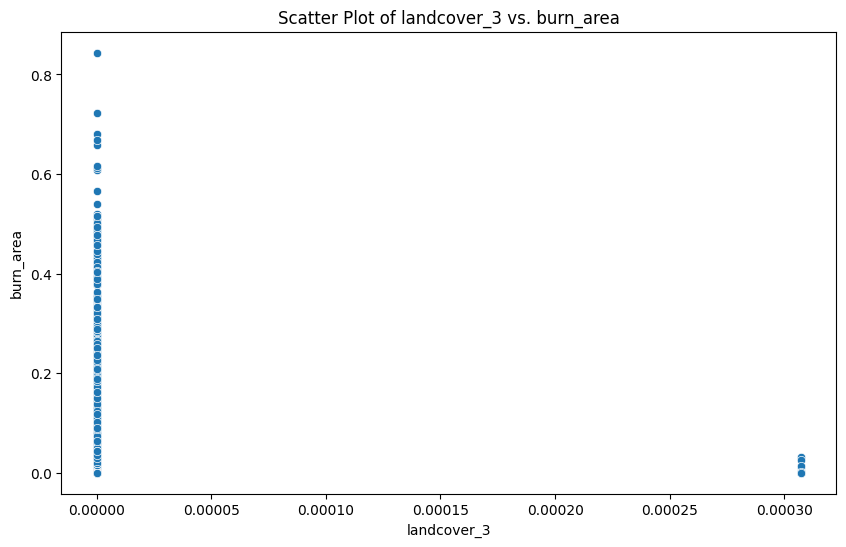

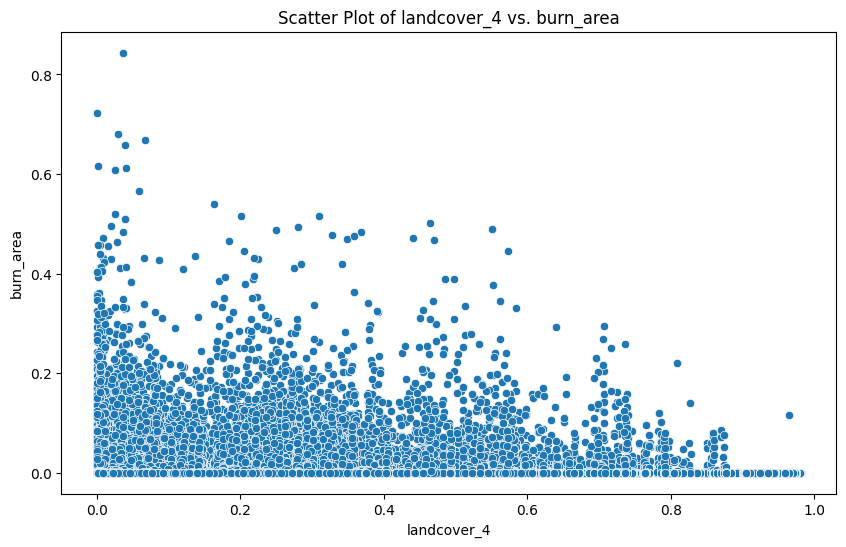

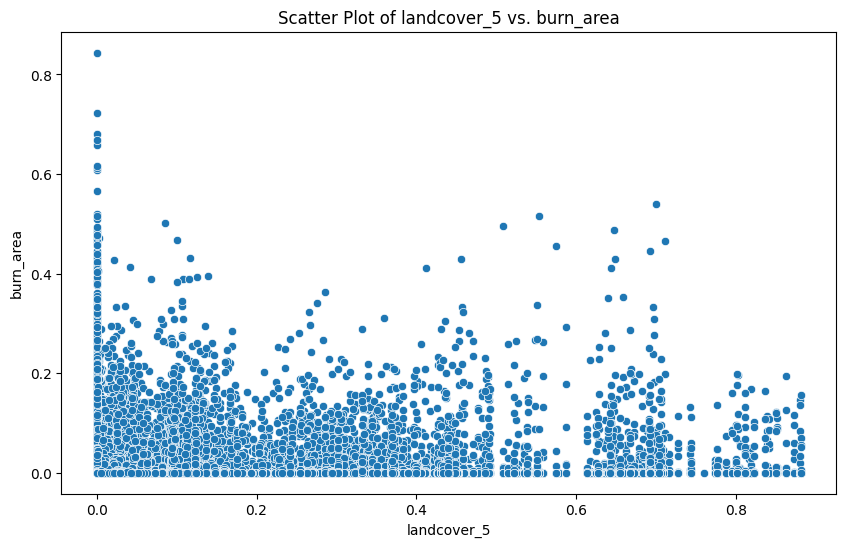

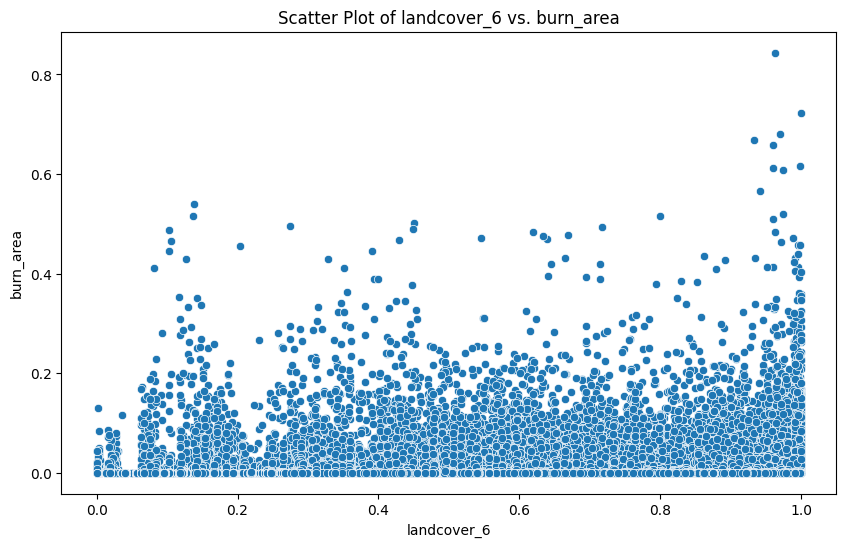

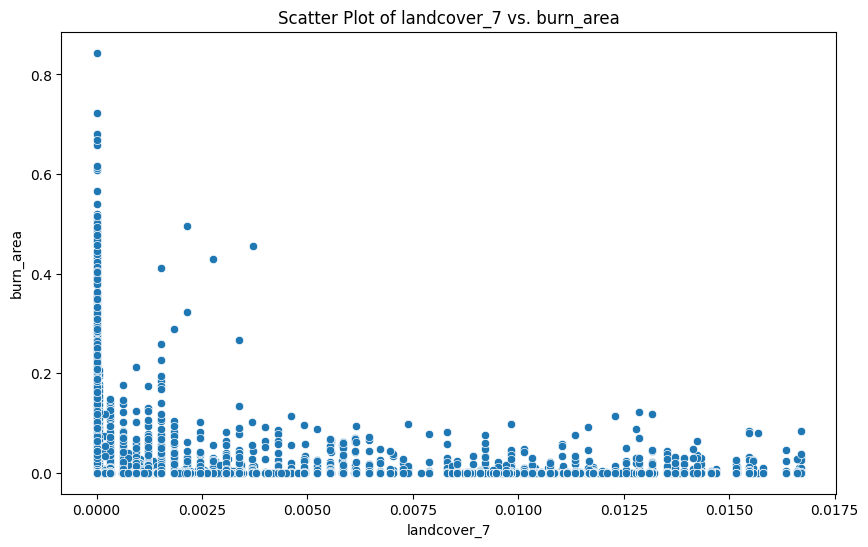

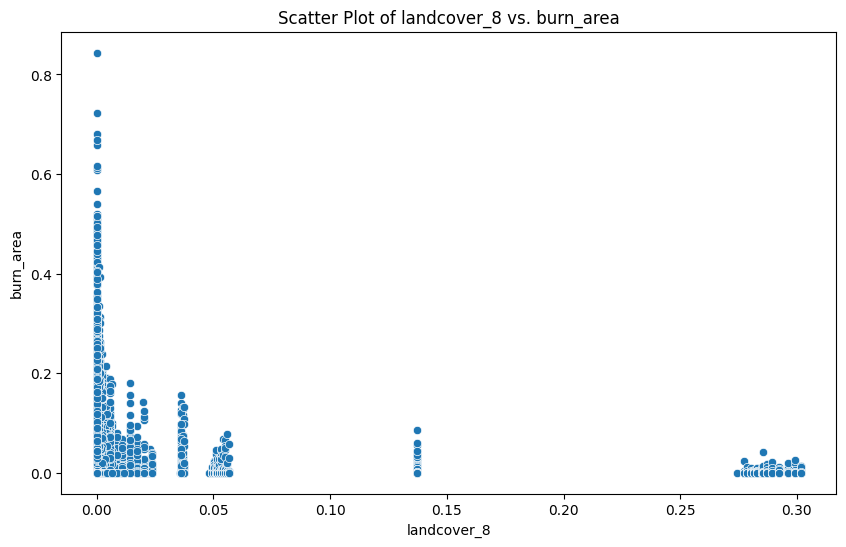

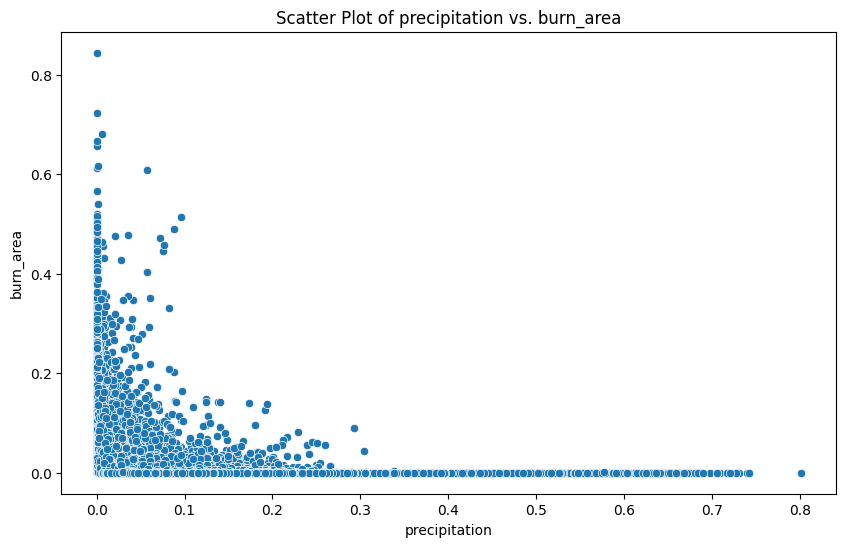

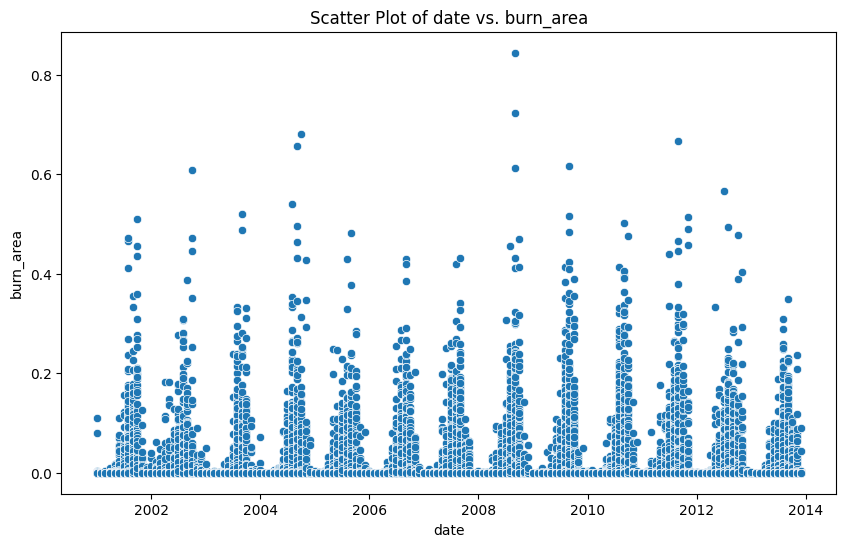

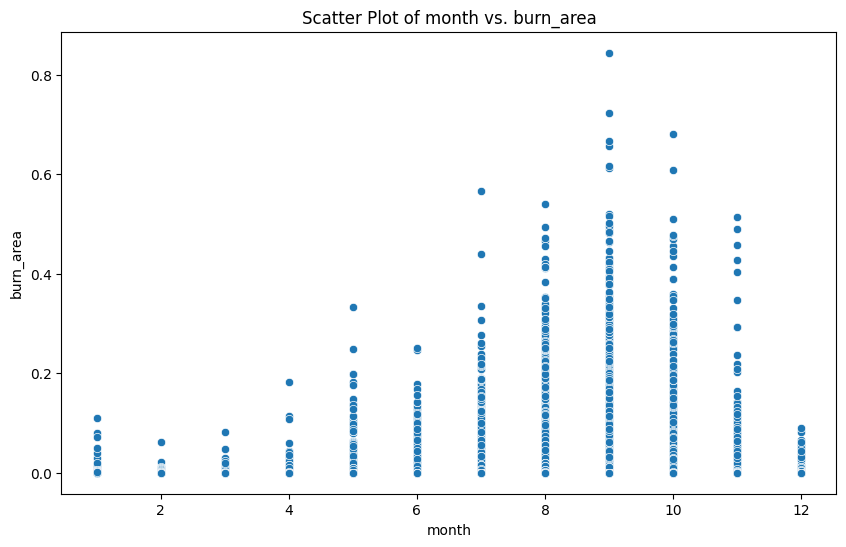

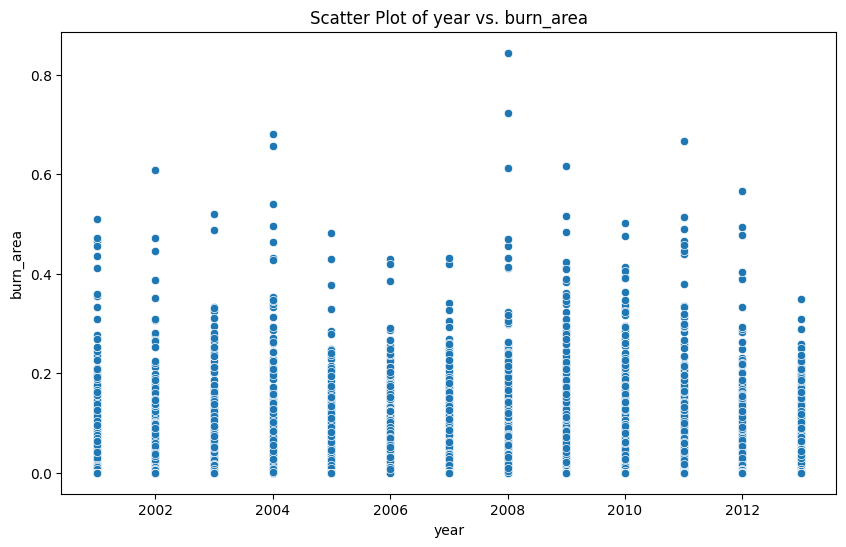

In [ ]:
import seaborn as sns

target_col = 'burn_area'

for feature in train.columns:
  if feature != target_col:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=train, x=feature, y=target_col)
    plt.title(f'Scatter Plot of {feature} vs. {target_col}')
    plt.xlabel(feature)
    plt.ylabel(target_col)
    plt.show()

In [ ]:

train = train.drop('ID', axis=1)


In [ ]:
test = test.drop('ID', axis=1)

### Removing Collinearity

In [ ]:
corr_matrix = train.corr()

# setting a threshold for the correlation matrix
threshold = 0.75
column_to_remove = set()
for i in range(len(corr_matrix.columns)):
  for j in range(i):
    if abs(corr_matrix.iloc[i, j]) >= threshold and i!=j:
      colname = corr_matrix.columns[i]
      column_to_remove.add(colname)

train_reduced = train.drop(columns=column_to_remove)



In [ ]:
train_all = train_reduced.copy().dropna()
train = train_all.loc[train_all.date < '2011-01-01']
valid = train_all.loc[train_all.date > '2011-01-01']
print(train.shape, valid.shape)

(63960, 22) (18655, 22)


In [ ]:
target_col = 'burn_area'
in_cols = [col for col in train_all.columns if col != target_col and col != 'date']


In [ ]:
 # Get our X and y training and validation sets ready
X_train, y_train = train[in_cols], train[target_col]
X_valid, y_valid = valid[in_cols], valid[target_col]

In [ ]:
train_reduced.head()

,lat,lon,burn_area,climate_aet,climate_pdsi,climate_pet,climate_ro,climate_soil,climate_swe,climate_tmmn,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_7,landcover_8,date,month
0,-15.858835,29.237029,0.0,1195,263,1195,10,1692,0,211,...,0.0,0.0,0.018654,0.0,0.714446,0.012174,0.009836,0.0,2001-01-01,1
1,-15.858835,29.487029,0.0,1196,232,1196,10,1859,0,211,...,0.0,0.0,0.000000,0.0,0.654783,0.000095,0.000000,0.0,2001-01-01,1
2,-15.858835,29.737029,0.0,1190,314,1190,10,1677,0,208,...,0.0,0.0,0.000000,0.0,0.516421,0.000000,0.000000,0.0,2001-01-01,1
3,-15.858835,29.987029,0.0,1144,321,1144,66,1061,0,196,...,0.0,0.0,0.000000,0.0,0.299000,0.163902,0.000000,0.0,2001-01-01,1
4,-15.858835,30.237029,0.0,1187,413,1187,9,1714,0,204,...,0.0,0.0,0.000000,0.0,0.277392,0.067742,0.000000,0.0,2001-01-01,1


## Adding more features - some ideas




*   Read the list of climate variables and what they mean. See if you can combine them in interesting ways - perhaps a 'hot_and_dry' metric...
*   Fire depends on some processes that take a long time - for example, there may be more fuel if the previous growing season was a good one. Consider some lagged variables to give the model some inputs for what came before the current month.
*   Make some categorical features - 'dominant_land_type' or 'is_peak_rainfall'.
*   ...



# Data Split for Validation

We don't want to just split randomly - this would give us artificially high scores. Instead, let's use the last 3 years of the dataset for validation to more closely match the test configuration.

### Feature Selection

# Simple Model

In [ ]:


# Create and fit the model
model = RidgeCV()
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_valid)

# Score
mean_squared_error(y_valid, preds)**0.5 # RMSE - should match Zindi score. Lower is better

0.02692596324520746

In [ ]:
# Exercise. Try a RandomForestRegressor model. Use n_estimators=10 if the default takes too long to run, and experiment with the max_depth parameter.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)


In [ ]:
model2 = RandomForestRegressor(min_samples_split=2,min_samples_leaf=2,max_features='sqrt', n_estimators=1000, random_state=42)
model2.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=2,
                      n_estimators=1000, random_state=42)

In [ ]:
# Making predictions
y_pred = model2.predict(X_valid)

# Evaluating the model
mse = mean_squared_error(y_valid, y_pred)**0.5
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.022507405318554146


#### Hyperparameter tuning


In [ ]:
import pandas as pd
from sklearn.utils import shuffle

# Assuming X_train and y_train are your original datasets

# Define the fraction of data you want to sample, e.g., 10% of the data
fraction = 0.1

# Shuffle the dataset with a specific random state
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

# Select the subsample
X_train_small = X_train_shuffled[:int(fraction * len(X_train_shuffled))]
y_train_small = y_train_shuffled[:int(fraction * len(y_train_shuffled))]

# Now, X_train_small and y_train_small contain 10% of the shuffled data
print(f"Original X_train size: {len(X_train)}")
print(f"Subsampled X_train size: {len(X_train_small)}")


Original X_train size: 63960
Subsampled X_train size: 6396


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2', 0.5],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model2, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_small, y_train_small)
print(f"Best hyperparameters: {grid_search.best_params_}")

KeyboardInterrupt: 

In [ ]:
# Train the model with the best hyperparameters
best_params = grid_search.best_params_

best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)



RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=42)

In [ ]:
# Evaluate the model
y_pred = best_model.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f"Test RMSE: {rmse}")


Test RMSE: 0.02303162820759647


#### Model 2 - SVM

In [ ]:
train.head()

In [ ]:
# Train the SVR model
from sklearn.svm import SVR

svr_model = SVR(C= 10, epsilon= 0.1, gamma ='scale', kernel= 'rbf')  # 'rbf' is common for regression tasks
svr_model.fit(X_train, y_train)

# Make predictions
y_pred = svr_model.predict(X_valid)
# Evaluate the model
print(f"Root Mean Squared Error: {mean_squared_error(y_valid, y_pred)**0.5}")
print(f"R^2 Score: {r2_score(y_valid, y_pred):.2f}")

Root Mean Squared Error: 0.08664536410452935
R^2 Score: -7.71


In [ ]:
from sklearn.model_selection import GridSearchCV

svr = SVR()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.5, 0.3],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Setup the GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_small, y_train_small)

best_params = grid_search.best_params_
# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

NameError: name 'SVR' is not defined

In [ ]:
best_model = SVR(**best_params)
best_model.fit(X_train, y_train)


SVR(C=10)

In [ ]:
# Make predictions
y_pred = best_model.predict(X_valid)
# Evaluate the model
print(f"Root Mean Squared Error: {mean_squared_error(y_valid, y_pred)**0.5}")


Root Mean Squared Error: 0.052369726958325806


### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_features=None,subsample=1.0,min_samples_leaf=8,min_samples_split=2 ,max_depth=4,learning_rate=0.1,n_estimators=1000,random_state=42)
# Fit the model to the training data
gbr.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=4, min_samples_leaf=8, n_estimators=1000,
                          random_state=42)

In [ ]:
# Predict on the test data
# Make predictions
y_pred = gbr.predict(X_valid)
# Evaluate the model

print(f"Root Mean Squared Error: {mean_squared_error(y_valid, y_pred)**0.5}")


Root Mean Squared Error: 0.023190228284641297


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [1000],        # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Step size shrinkage
    'max_depth': [3, 4, 5],                 # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],          # Minimum number of samples required to be at a leaf node
    'subsample': [0.8, 0.9, 1.0],           # Fraction of samples used for fitting the individual base learners
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train_small, y_train_small)

# Get the best parameters
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)



Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


In [ ]:
best_model = gbr(**best_params)
best_model.fit(X_train, y_train)


In [ ]:
# Use the best model to make predictions
best_model = grid_search.best_estimator_  # or random_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_valid)

# Calculate Mean Squared Error
mse = mean_squared_error(y_valid, y_pred)
print(f"Test Set Mean Squared Error: {mse}")


### Lasso Regression

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score


# Initialize the Lasso Regression model with a specific alpha value
lasso_regressor = Lasso( alpha= 0.001, random_state=42)

# Fit the model to the training data
lasso_regressor.fit(X_train, y_train)



Lasso(alpha=0.001, random_state=42)

In [ ]:

# Predict on the test set
y_pred = lasso_regressor.predict(X_valid)

# Evaluate the model performance
rmse = mean_squared_error(y_valid, y_pred)**0.5

print(f"Mean Squared Error: {rmse}")


Mean Squared Error: 0.027320190553640867


### Linear Regression

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Fit the model to the training data
linear_regressor.fit(X_train, y_train)


NameError: name 'X_train' is not defined

In [ ]:
# Predict on the test set
y_pred = linear_regressor.predict(X_valid)

# Evaluate the model performance
mse = mean_squared_error(y_valid, y_pred)**0.5
r2 = r2_score(y_valid, y_pred)

print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.026925221038086387


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Create a pipeline that first creates polynomial features and then applies linear regression
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])

# Define the hyperparameter grid to search (degree of polynomial features)
param_grid = {
    'poly_features__degree': [1, 2, 3, 4, 5]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=1)

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_degree = grid_search.best_params_['poly_features__degree']
print(f"Best degree for polynomial features: {best_degree}")


NameError: name 'LinearRegression' is not defined

In [ ]:

# Use the best model to predict on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)

# Evaluate the model performance
rmse = mean_squared_error(y_valid, y_pred)**0.5

print(f"Mean Squared Error: {rmse}")


### Decision Tree Regression

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Decision Tree Regressor
decision_tree = DecisionTreeRegressor(max_depth= 5, max_features ='sqrt', min_samples_leaf=1, min_samples_split= 20, random_state=42
)

# Fit the model
decision_tree.fit(X_train, y_train)




DecisionTreeRegressor(max_depth=5, max_features='sqrt', min_samples_split=20,
                      random_state=42)

In [ ]:
# Predict on the test set
y_pred_tree = decision_tree.predict(X_valid)

# Evaluate the model performance
mse_tree = mean_squared_error(y_valid, y_pred_tree)**0.5
print(f"Mean Squared Error of the Decision Tree Regressor: {mse_tree}")

Mean Squared Error of the Decision Tree Regressor: 0.026786942408881263


In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Decision Tree Regressor
decision_tree = DecisionTreeRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [None, 5],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the model to the data
grid_search.fit(X_train_small, y_train_small)



GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [None, 5],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='neg_mean_squared_error')

In [ ]:
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")



Best Parameters: {'criterion': 'poisson', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [ ]:
best_model = DecisionTreeRegressor(**best_params)
best_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='poisson', max_depth=5, min_samples_leaf=10)

In [ ]:

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_valid)

# Evaluate the model performance
rmse_best = mean_squared_error(y_valid, y_pred_best)**0.5
print(f"Mean Squared Error of the best Decision Tree Regressor: {rmse_best}")

Mean Squared Error of the best Decision Tree Regressor: 0.026721312260619013


In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error




# Initialize the base regressors
gbr = GradientBoostingRegressor(subsample=1.0,min_samples_leaf=8,min_samples_split=2 ,max_depth=4,learning_rate=0.1,n_estimators=1000,random_state=42)
dt = DecisionTreeRegressor(criterion= 'poisson', max_depth= 5, max_features= None, min_samples_leaf= 10, min_samples_split= 2, random_state=42)
rf = RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=42)

# Create the ensemble model using VotingRegressor
ensemble = VotingRegressor(estimators=[('gbr', gbr), ('dt', dt), ('rf', rf)])

# Fit the ensemble model
ensemble.fit(X_train, y_train)




VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(max_depth=4,
                                                       min_samples_leaf=8,
                                                       n_estimators=1000,
                                                       random_state=42)),
                            ('dt',
                             DecisionTreeRegressor(criterion='poisson',
                                                   max_depth=5,
                                                   min_samples_leaf=10,
                                                   random_state=42)),
                            ('rf',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=200,
                                                   random_state=42))])

In [ ]:
# Predict on the test set
y_pred = ensemble.predict(X_valid)

# Evaluate the model performance
rmse = mean_squared_error(y_valid, y_pred)**0.5
print(f"Mean Squared Error of the ensemble: {rmse}")

Mean Squared Error of the ensemble: 0.022826481498779343


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression



# Define the base models
estimators = [
    ('gbr', GradientBoostingRegressor(max_features=None,subsample=1.0,min_samples_leaf=8,min_samples_split=2 ,max_depth=4,learning_rate=0.1,n_estimators=1000,random_state=42)),
    ('dt', DecisionTreeRegressor(criterion= 'poisson', max_depth= 5, max_features= None, min_samples_leaf= 10, min_samples_split= 2,random_state=42)),
    ('rf', RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=42))
]

# Define the stacking regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Fit the stacking model
stacking_regressor.fit(X_train, y_train)



StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(max_depth=4,
                                                         min_samples_leaf=8,
                                                         n_estimators=1000,
                                                         random_state=42)),
                              ('dt',
                               DecisionTreeRegressor(criterion='poisson',
                                                     max_depth=5,
                                                     min_samples_leaf=10,
                                                     random_state=42)),
                              ('rf',
                               RandomForestRegressor(max_features='sqrt',
                                                     n_estimators=200,
                                                     random_state=42))],
                  final_estimator=LinearRegression())

In [ ]:
# Predict on the test set
y_pred_stack = stacking_regressor.predict(X_valid)

# Evaluate the model performance
mse_stack = mean_squared_error(y_valid, y_pred_stack)**0.5
print(f"Mean Squared Error of the stacking ensemble: {mse_stack}")

Mean Squared Error of the stacking ensemble: 0.025721142526952085


In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

# Initialize the base regressor
base_regressor = RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=42)



# Create the Bagging Regressor
bagging_regressor = BaggingRegressor(estimator=base_regressor, n_estimators=50, max_features=12, random_state=42)

# Fit the model
bagging_regressor.fit(X_train, y_train)




In [ ]:
# Predict on the test set
y_pred_bagging = bagging_regressor.predict(X_valid)

# Evaluate the model performance
mse_bagging = mean_squared_error(y_valid, y_pred_bagging)**0.5
print(f"Mean Squared Error of the Bagging Regressor: {mse_bagging}")

Mean Squared Error of the Bagging Regressor: 0.022623010427128123


In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

# Initialize the base regressor
svr = SVR()

# Initialize the Bagging Regressor
bagging_svr = BaggingRegressor(estimator=svr, n_estimators=10, random_state=42)

# Fit the model to the training data
bagging_svr.fit(X_train, y_train)

# Predict on the test set
y_pred = bagging_svr.predict(X_valid)
# Evaluate the model performance
mse_svr_bagging = mean_squared_error(y_valid, y_pred)**0.5
print(f"Mean Squared Error of the Bagging Regressor: {mse_svr_bagging}")


KeyboardInterrupt: 

# Making A Submission

Once you've got some features and a model you're happy with, it's time to submit!

In [ ]:
# Look at the sample submission file
ss = pd.read_csv('/content/drive/My Drive/fire-extent-prediction-challenge/SampleSubmission.csv')

ss.head()

,ID,burn_area
0,0_2014-01-01,0
1,1_2014-01-01,0
2,2_2014-01-01,0
3,3_2014-01-01,0
4,4_2014-01-01,0


In [ ]:
# And the test data
test.head()

,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,...,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation,date,month,year
0,-15.858835,29.237029,1146,74,-451,1220,120,6,212,1974,...,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243,2014-01-01,1,2014
1,-15.858835,29.487029,1118,98,-405,1216,117,6,330,1973,...,0.0,0.406436,0.000446,0.593118,0.000000,0.0,0.421489,2014-01-01,1,2014
2,-15.858835,29.737029,1067,137,-468,1204,111,6,194,1958,...,0.0,0.254791,0.000000,0.745209,0.000000,0.0,0.419122,2014-01-01,1,2014
3,-15.858835,29.987029,969,187,-533,1156,101,5,78,1954,...,0.0,0.219340,0.182153,0.598507,0.000000,0.0,0.404596,2014-01-01,1,2014
4,-15.858835,30.237029,927,270,-505,1197,96,5,139,1939,...,0.0,0.220239,0.097748,0.682013,0.000000,0.0,0.371100,2014-01-01,1,2014


In [ ]:
print(column_to_remove)

{'climate_pr', 'landcover_6', 'year', 'climate_srad', 'climate_tmmx', 'climate_def', 'precipitation', 'climate_vpd', 'climate_vap'}


In [ ]:
test_reduced = test.drop(['landcover_6', 'climate_tmmx', 'climate_vap', 'climate_def', 'climate_vpd', 'climate_srad', 'climate_pr', 'precipitation'], axis=1)


In [ ]:
test_reduced.head()

,lat,lon,climate_aet,climate_pdsi,climate_pet,climate_ro,climate_soil,climate_swe,climate_tmmn,climate_vs,...,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_7,landcover_8,date,month,year
0,-15.858835,29.237029,1146,-451,1220,6,212,0,217,148,...,0.000615,0.015418,0.0,0.416704,0.023724,0.013524,0.0,2014-01-01,1,2014
1,-15.858835,29.487029,1118,-405,1216,6,330,0,216,143,...,0.000000,0.000000,0.0,0.406436,0.000446,0.000000,0.0,2014-01-01,1,2014
2,-15.858835,29.737029,1067,-468,1204,6,194,0,214,143,...,0.000000,0.000000,0.0,0.254791,0.000000,0.000000,0.0,2014-01-01,1,2014
3,-15.858835,29.987029,969,-533,1156,5,78,0,202,122,...,0.000000,0.000000,0.0,0.219340,0.182153,0.000000,0.0,2014-01-01,1,2014
4,-15.858835,30.237029,927,-505,1197,5,139,0,210,143,...,0.000000,0.000000,0.0,0.220239,0.097748,0.000000,0.0,2014-01-01,1,2014


In [ ]:
# So we need to predict the burn area for each row in test.

# Add the same features to test as we did to train:
#test['month'] = test_reduced.date.dt.month
#test['year'] = test_reduced.date.dt.year

# Get predictions
preds = stacking_regressor.predict(test_reduced[in_cols].fillna(0)) # fillna(0) here could be improved by examining the missing data and filling more appropriately.

# Add to submission dataframe
ss['burn_area'] = preds

# Depending on your model, you may have some predictions that don't make sense. Let's constrain our predictions to the range (0, 1)
ss['burn_area'] = ss['burn_area'].clip(0, 1)

# View
ss.head()

,ID,burn_area
0,0_2014-01-01,0.000160
1,1_2014-01-01,0.000000
2,2_2014-01-01,0.000000
3,3_2014-01-01,0.001735
4,4_2014-01-01,0.001779


In [ ]:
# Save ready for submission:
ss.to_csv('10th_submission.csv', index=False)

# Tips for improving your score

- Once you've chosen a model, you should re-train it on all the data (including that which you previously held back for validation) to give it the best chance of succeeding
- There is a timeseries component to this challenge. Think about how to use this to improve your accuracy.
- Spend some time on feature engineering. Since no external data is allowed for this challenge, the winning solution will be the one that gets the most out of the data provided.